In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, accuracy_score,
                             precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, ttest_ind, kstest, uniform, randint
try:
    import shap
    SHAP_AVAILABLE = True
except:
    print(" SHAP not installed. Install with: pip install shap")
    SHAP_AVAILABLE = False
import joblib
import os
import time
import subprocess

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('outputs/graphs', exist_ok=True)
os.makedirs('outputs/datasets', exist_ok=True)
os.makedirs('outputs/models', exist_ok=True)
os.makedirs('outputs/predictions', exist_ok=True)

In [2]:
def detect_gpu():
    gpu_available = False
    gpu_info = {}
    
    # Method 1: Check NVIDIA GPU via nvidia-smi
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,driver_version', 
                                '--format=csv,noheader'], 
                               capture_output=True, text=True, timeout=5)
        if result.returncode == 0:
            gpu_available = True
            gpu_data = result.stdout.strip().split(',')
            gpu_info['name'] = gpu_data[0].strip() if len(gpu_data) > 0 else 'Unknown'
            gpu_info['memory'] = gpu_data[1].strip() if len(gpu_data) > 1 else 'Unknown'
            gpu_info['driver'] = gpu_data[2].strip() if len(gpu_data) > 2 else 'Unknown'
            print(" NVIDIA GPU Detected via nvidia-smi")
            print(f"  GPU Name: {gpu_info['name']}")
            print(f"  GPU Memory: {gpu_info['memory']}")
            print(f"  Driver Version: {gpu_info['driver']}")
    except (subprocess.TimeoutExpired, FileNotFoundError, Exception) as e:
        print(f"  nvidia-smi check: Not available")
    
    # Method 2: Check CUDA via PyTorch (if installed)
    try:
        import torch
        if torch.cuda.is_available():
            gpu_available = True
            gpu_info['cuda_version'] = torch.version.cuda
            gpu_info['device_count'] = torch.cuda.device_count()
            if 'name' not in gpu_info:
                gpu_info['name'] = torch.cuda.get_device_name(0)
            print(" CUDA Available via PyTorch")
            print(f"  CUDA Version: {gpu_info['cuda_version']}")
            print(f"  GPU Count: {gpu_info['device_count']}")
    except ImportError:
        print("  PyTorch CUDA check: PyTorch not installed")
    except Exception as e:
        print(f"  PyTorch CUDA check: {e}")
    
    # Method 3: Check XGBoost GPU support
    try:
        # Test XGBoost GPU capability
        test_model = XGBClassifier(device='cuda', tree_method='hist', n_estimators=1)
        test_X = np.random.rand(100, 10)
        test_y = np.random.randint(0, 2, 100)
        test_model.fit(test_X, test_y)
        gpu_available = True
        gpu_info['xgboost_gpu'] = True
        print(" XGBoost GPU support confirmed")
    except Exception as e:
        gpu_info['xgboost_gpu'] = False
        print(f"  XGBoost GPU check: {str(e)[:50]}")
    
    return gpu_available, gpu_info

# Detect GPU
GPU_AVAILABLE, GPU_INFO = detect_gpu()

# Configure device settings
if GPU_AVAILABLE:
    DEVICE = 'cuda'
    TREE_METHOD = 'hist'  # XGBoost 2.0+ uses 'hist' for GPU
    N_JOBS = 1  # GPU training uses single job
    print(f"\n GPU Mode Enabled")
    print(f"  Device: {DEVICE}")
    print(f"  Tree Method: {TREE_METHOD}")
else:
    DEVICE = 'cpu'
    TREE_METHOD = 'hist'
    N_JOBS = -1  # CPU uses all cores
    print(f"\n GPU Not Available - Using CPU")
    print(f"  Device: {DEVICE}")
    print(f"  Tree Method: {TREE_METHOD}")
    print(f"  CPU Cores: All available")

print("\nPerformance Mode:")
print(f"  XGBoost will run on: {DEVICE.upper()}")
print(f"  Parallel jobs (n_jobs): {N_JOBS}")

 NVIDIA GPU Detected via nvidia-smi
  GPU Name: Tesla T4
  GPU Memory: 15360 MiB
  Driver Version: 560.35.03
Tesla T4
 CUDA Available via PyTorch
  CUDA Version: 12.4
  GPU Count: 2
 XGBoost GPU support confirmed

 GPU Mode Enabled
  Device: cuda
  Tree Method: hist

Performance Mode:
  XGBoost will run on: CUDA
  Parallel jobs (n_jobs): 1


In [4]:
print("\n" + "="*80)
print("DATA LOADING")
print("="*80)

df_original = pd.read_csv('/kaggle/input/dsc-project-dataset/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

print(f" Dataset loaded successfully")
print(f"  Shape: {df_original.shape}")
print(f"  Features: {df_original.shape[1]}")
print(f"  Samples: {df_original.shape[0]}")


DATA LOADING
 Dataset loaded successfully
  Shape: (70692, 22)
  Features: 22
  Samples: 70692



EDA

Dataset Info:
  Columns: ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'BMI']... (22 total)
  Missing Values: 0
  Duplicates: 1635

Target Distribution:
Diabetes_binary
0.0    35346
1.0    35346
Name: count, dtype: int64

Class Balance:
Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64

 Descriptive statistics calculated


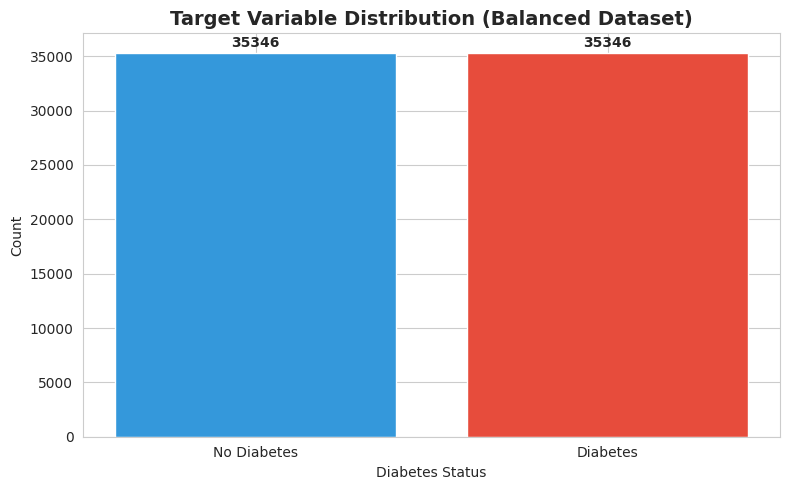

 Graph saved: 01_target_distribution.png


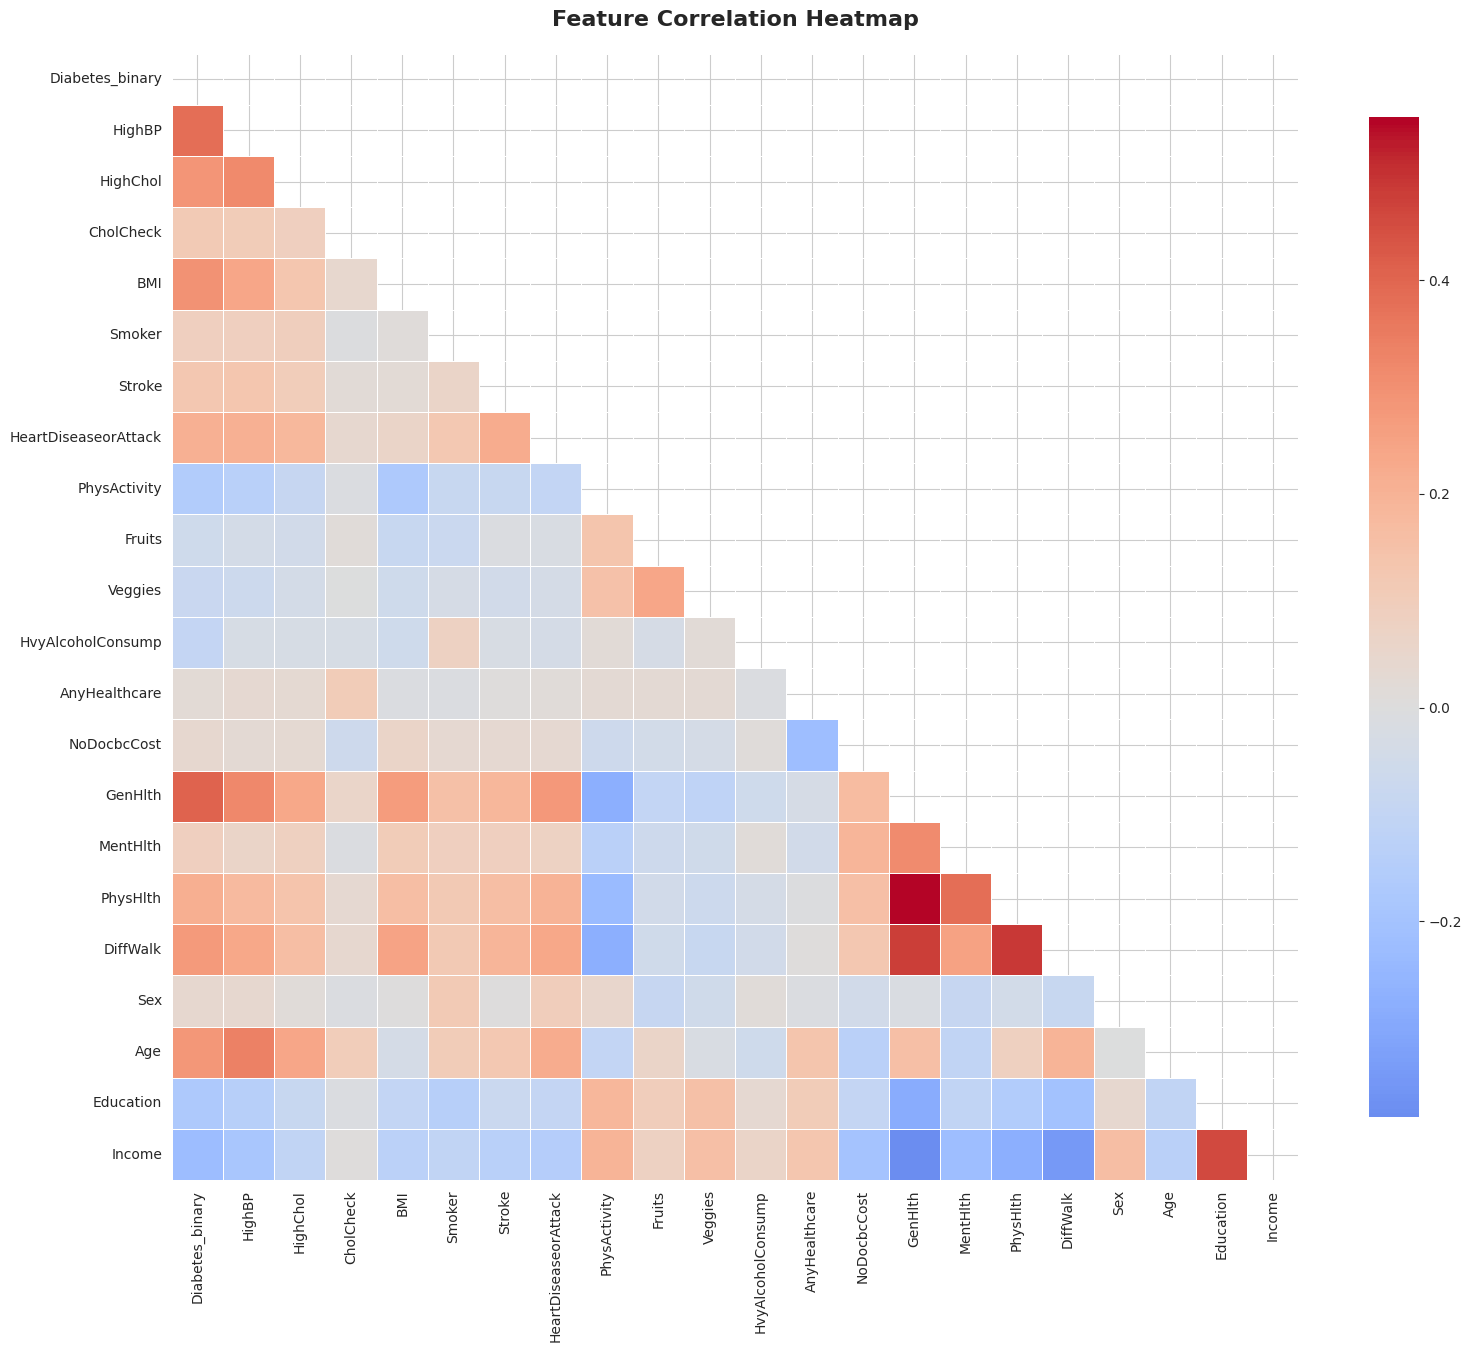

 Graph saved: 02_correlation_heatmap.png

Top 5 Features Correlated with Diabetes:
  1. GenHlth: 0.4076
  2. HighBP: 0.3815
  3. BMI: 0.2934
  4. HighChol: 0.2892
  5. Age: 0.2787


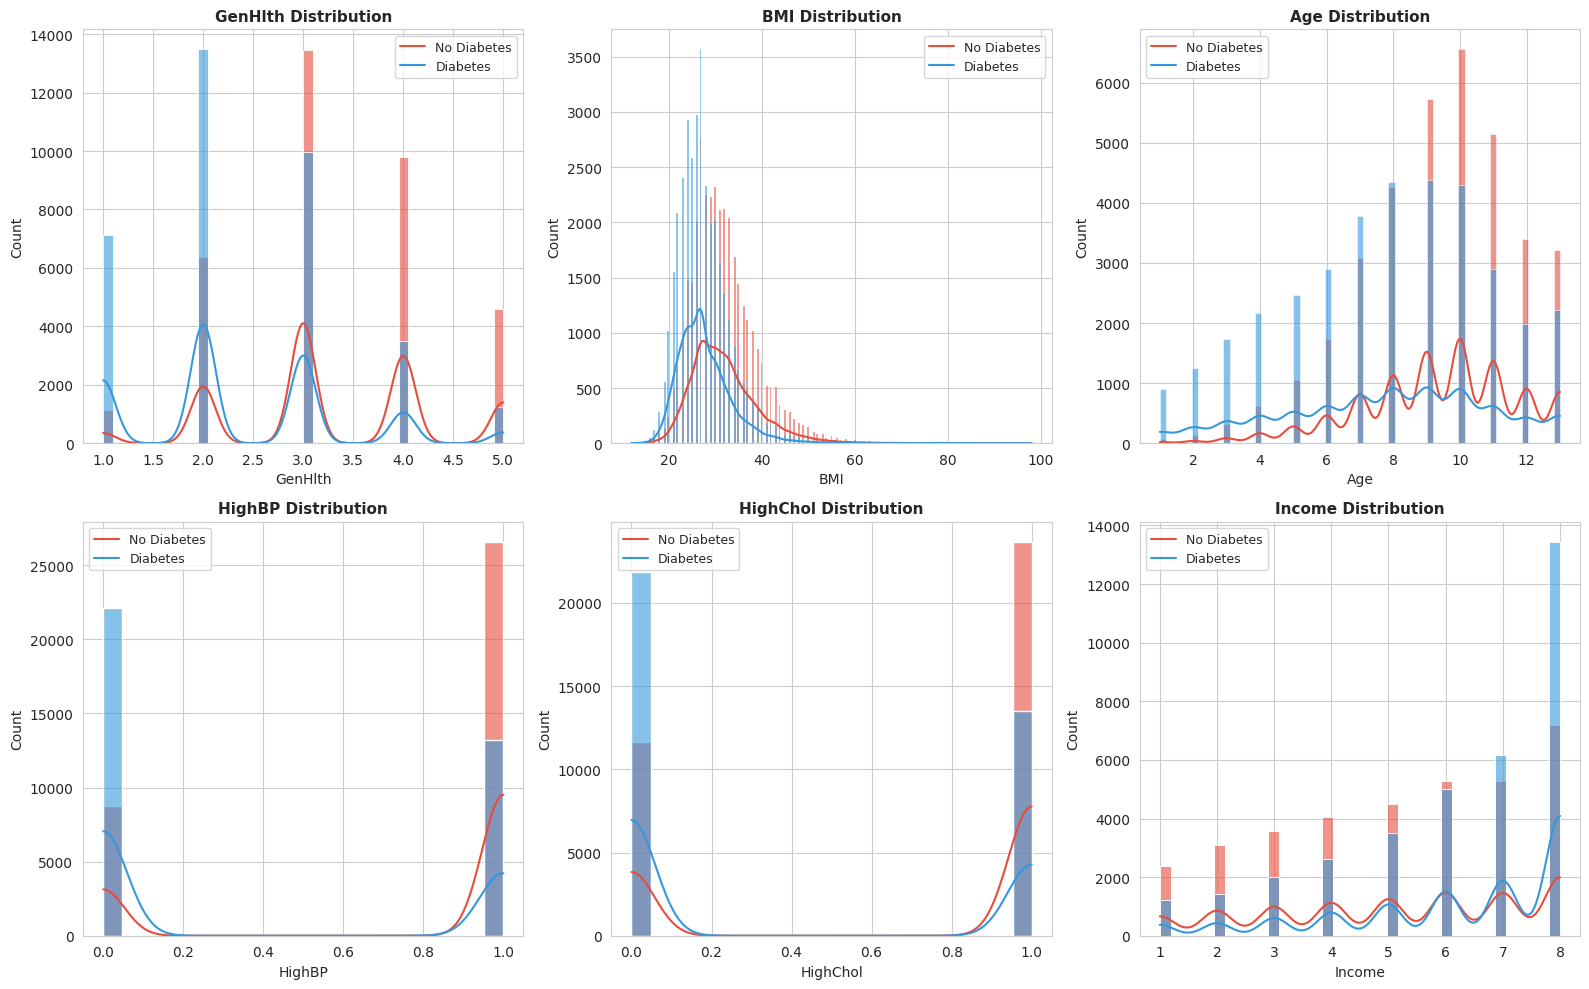

 Graph saved: 03_feature_distributions.png


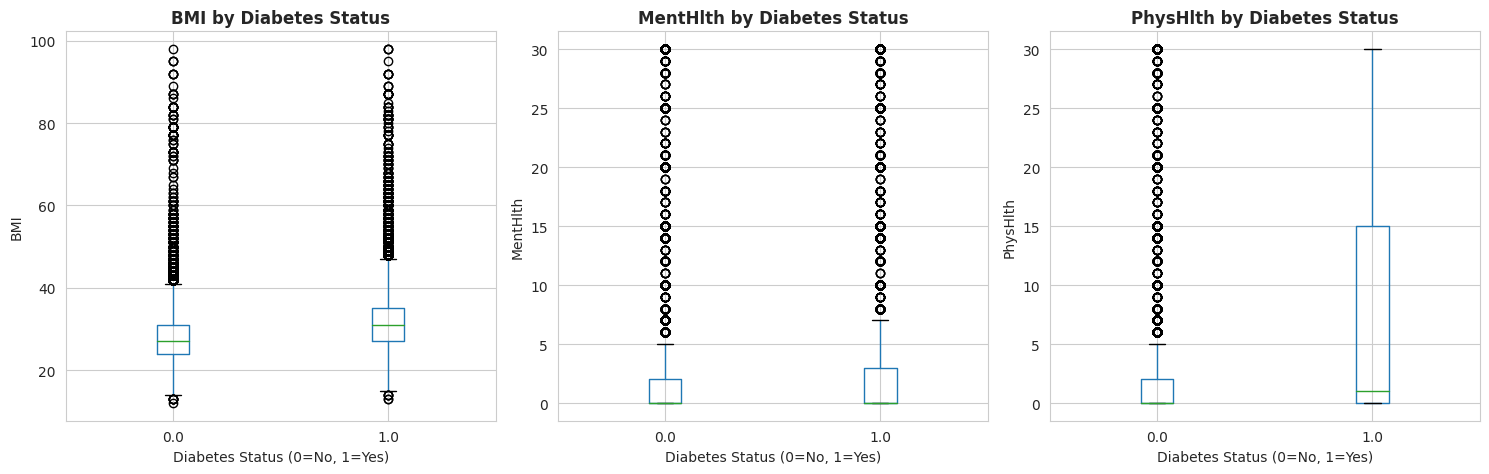

 Graph saved: 04_boxplots.png


In [5]:
print("\n" + "="*80)
print("EDA")
print("="*80)

df = df_original.copy()

print("\nDataset Info:")
print(f"  Columns: {list(df.columns)[:5]}... ({len(df.columns)} total)")
print(f"  Missing Values: {df.isnull().sum().sum()}")
print(f"  Duplicates: {df.duplicated().sum()}")

target_dist = df['Diabetes_binary'].value_counts()
print(f"\nTarget Distribution:")
print(target_dist)
print(f"\nClass Balance:")
print(df['Diabetes_binary'].value_counts(normalize=True))

desc_stats = df.describe()
print("\n Descriptive statistics calculated")

# GRAPH 1: Target Distribution
plt.figure(figsize=(8, 5))
target_counts = df['Diabetes_binary'].value_counts()
plt.bar(['No Diabetes', 'Diabetes'], target_counts.values, color=['#3498db', '#e74c3c'])
plt.title('Target Variable Distribution (Balanced Dataset)', fontsize=14, fontweight='bold')
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/graphs/01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 01_target_distribution.png")

# GRAPH 2: Correlation Heatmap
plt.figure(figsize=(16, 14))
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('outputs/graphs/02_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 02_correlation_heatmap.png")

target_corr = correlation_matrix['Diabetes_binary'].sort_values(ascending=False)
print("\nTop 5 Features Correlated with Diabetes:")
for i, (feature, corr) in enumerate(target_corr[1:6].items(), 1):
    print(f"  {i}. {feature}: {corr:.4f}")

# GRAPH 3: Feature Distributions
key_features = ['GenHlth', 'BMI', 'Age', 'HighBP', 'HighChol', 'Income']
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    sns.histplot(data=df, x=feature, hue='Diabetes_binary', 
                 kde=True, ax=axes[idx], palette=['#3498db', '#e74c3c'], alpha=0.6)
    axes[idx].set_title(f'{feature} Distribution', fontweight='bold', fontsize=11)
    axes[idx].set_xlabel(feature, fontsize=10)
    axes[idx].set_ylabel('Count', fontsize=10)
    axes[idx].legend(['No Diabetes', 'Diabetes'], fontsize=9)

plt.tight_layout()
plt.savefig('outputs/graphs/03_feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 03_feature_distributions.png")

# GRAPH 4: Boxplots
continuous_features = ['BMI', 'MentHlth', 'PhysHlth']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, feature in enumerate(continuous_features):
    df.boxplot(column=feature, by='Diabetes_binary', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Diabetes Status', fontweight='bold')
    axes[idx].set_xlabel('Diabetes Status (0=No, 1=Yes)')
    axes[idx].set_ylabel(feature)

plt.suptitle('')
plt.tight_layout()
plt.savefig('outputs/graphs/04_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 04_boxplots.png")

In [6]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

def engineer_features(dataframe):
    """Apply feature engineering transformations"""
    df_engineered = dataframe.copy()
    
    df_engineered['HealthScore'] = (df_engineered['GenHlth'] + 
                                     df_engineered['PhysHlth'] + 
                                     df_engineered['MentHlth']) / 3
    
    risk_factors = ['HighBP', 'HighChol', 'Smoker', 'HeartDiseaseorAttack', 'Stroke']
    df_engineered['RiskFactorCount'] = df_engineered[risk_factors].sum(axis=1)
    
    return df_engineered

df = engineer_features(df)

print(" Feature engineering completed")
print(f"  New features created: HealthScore, RiskFactorCount")
print(f"  Total features: {df.shape[1] - 1}")


FEATURE ENGINEERING
 Feature engineering completed
  New features created: HealthScore, RiskFactorCount
  Total features: 23


In [7]:
print("\n" + "="*80)
print("DATA PREPROCESSING")
print("="*80)

print(f"Missing values: {df.isnull().sum().sum()}")

duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    df = df.drop_duplicates()
    print(f" Removed {duplicates} duplicate rows")

# Outlier handling
Q1 = df['BMI'].quantile(0.25)
Q3 = df['BMI'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

outliers = df[(df['BMI'] < lower_bound) | (df['BMI'] > upper_bound)]
print(f"\nOutliers detected in BMI: {len(outliers)}")
print(f"  Lower bound: {lower_bound:.2f}")
print(f"  Upper bound: {upper_bound:.2f}")

df['BMI'] = df['BMI'].clip(lower=lower_bound, upper=upper_bound)
print(" Outliers capped")

processed_file = 'outputs/datasets/processed_dataset.csv'
df.to_csv(processed_file, index=False)
print(f"\n Processed dataset saved: {processed_file}")
print(f"  Shape: {df.shape}")


DATA PREPROCESSING
Missing values: 0
Duplicate rows: 1635
 Removed 1635 duplicate rows

Outliers detected in BMI: 358
  Lower bound: 1.00
  Upper bound: 57.00
 Outliers capped

 Processed dataset saved: outputs/datasets/processed_dataset.csv
  Shape: (69057, 24)



TRAIN-TEST SPLIT
 Data split completed (80-20, stratified)
  Training samples: 55245
  Testing samples: 13812
  Features: 23

 Train dataset saved: outputs/datasets/train_dataset.csv
 Test dataset saved: outputs/datasets/test_dataset.csv
 Feature scaling completed (StandardScaler)


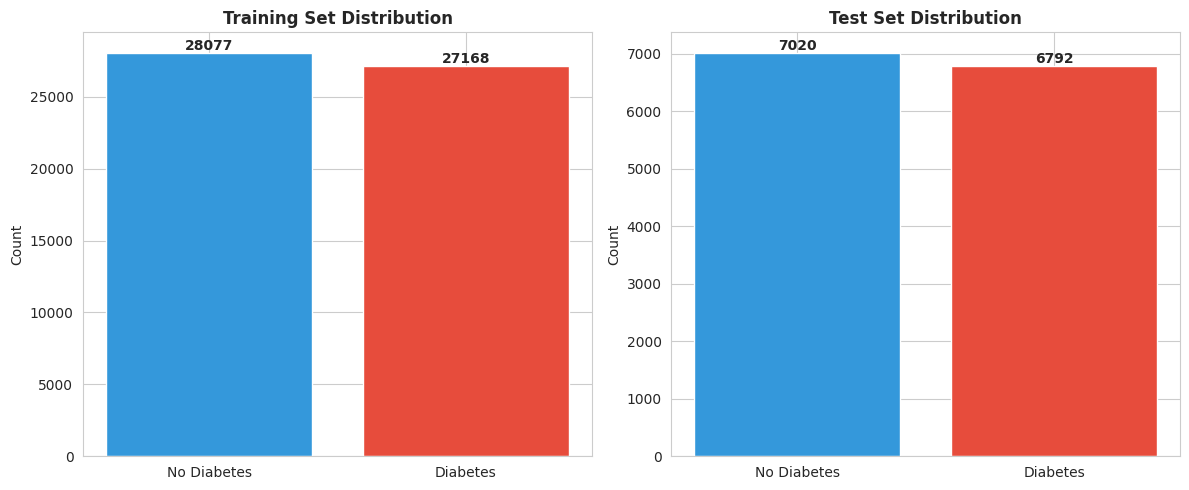

 Graph saved: 05_train_test_distribution.png


In [8]:

print("\n" + "="*80)
print("TRAIN-TEST SPLIT")
print("="*80)

X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Data split completed (80-20, stratified)")
print(f"  Training samples: {X_train.shape[0]}")
print(f"  Testing samples: {X_test.shape[0]}")
print(f"  Features: {X_train.shape[1]}")

train_data = X_train.copy()
train_data['Diabetes_binary'] = y_train
test_data = X_test.copy()
test_data['Diabetes_binary'] = y_test

train_file = 'outputs/datasets/train_dataset.csv'
test_file = 'outputs/datasets/test_dataset.csv'

train_data.to_csv(train_file, index=False)
test_data.to_csv(test_file, index=False)

print(f"\n Train dataset saved: {train_file}")
print(f" Test dataset saved: {test_file}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(" Feature scaling completed (StandardScaler)")

# GRAPH 5: Train-Test Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

train_counts = y_train.value_counts()
axes[0].bar(['No Diabetes', 'Diabetes'], train_counts.values, color=['#3498db', '#e74c3c'])
axes[0].set_title('Training Set Distribution', fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(train_counts.values):
    axes[0].text(i, v + 200, str(v), ha='center', fontweight='bold')

test_counts = y_test.value_counts()
axes[1].bar(['No Diabetes', 'Diabetes'], test_counts.values, color=['#3498db', '#e74c3c'])
axes[1].set_title('Test Set Distribution', fontweight='bold')
axes[1].set_ylabel('Count')
for i, v in enumerate(test_counts.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('outputs/graphs/05_train_test_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 05_train_test_distribution.png")

In [11]:
print("\n" + "="*80)
print(f"BASELINE MODEL TRAINING")
print("="*80)

models = {}
predictions = {}
probabilities = {}
training_times = {}

# Model 1: Logistic Regression (CPU)
print("\n[1/3] Training Logistic Regression...")
start_time = time.time()
log_reg = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
log_reg.fit(X_train_scaled, y_train)
training_times['Logistic Regression'] = time.time() - start_time
models['Logistic Regression'] = log_reg
predictions['Logistic Regression'] = log_reg.predict(X_test_scaled)
probabilities['Logistic Regression'] = log_reg.predict_proba(X_test_scaled)[:, 1]
print(f" Trained in {training_times['Logistic Regression']:.2f}s")

# Model 2: Random Forest
print("\n[2/3] Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
training_times['Random Forest'] = time.time() - start_time
models['Random Forest'] = rf_model
predictions['Random Forest'] = rf_model.predict(X_test)
probabilities['Random Forest'] = rf_model.predict_proba(X_test)[:, 1]
print(f" Trained in {training_times['Random Forest']:.2f}s")

# Model 3: XGBoost
print(f"\n[3/3] Training XGBoost...")
start_time = time.time()
xgb_model = XGBClassifier(
    device=DEVICE,              
    tree_method=TREE_METHOD,    
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
training_times['XGBoost'] = time.time() - start_time
models['XGBoost'] = xgb_model
predictions['XGBoost'] = xgb_model.predict(X_test)
probabilities['XGBoost'] = xgb_model.predict_proba(X_test)[:, 1]
print(f" Trained in {training_times['XGBoost']:.2f}s")

print(f"\nTraining Time Comparison:")
for model_name, t in training_times.items():
    print(f"  {model_name}: {t:.2f}s")


BASELINE MODEL TRAINING

[1/3] Training Logistic Regression...
 Trained in 0.70s

[2/3] Training Random Forest...
 Trained in 1.35s

[3/3] Training XGBoost...
 Trained in 0.41s

Training Time Comparison:
  Logistic Regression: 0.70s
  Random Forest: 1.35s
  XGBoost: 0.41s


In [12]:
print("\n" + "="*80)
print("MODEL EVALUATION")
print("="*80)

def evaluate_model(y_true, y_pred, y_proba, model_name):
    """Comprehensive model evaluation"""
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  ROC-AUC:   {roc_auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

results = {}
for model_name in models.keys():
    results[model_name] = evaluate_model(
        y_test, 
        predictions[model_name], 
        probabilities[model_name], 
        model_name
    )

comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*60)
print("BASELINE MODEL COMPARISON")
print("="*60)
print(comparison_df)

best_baseline = comparison_df['roc_auc'].idxmax()
print(f"\n Best Baseline: {best_baseline} (ROC-AUC: {comparison_df.loc[best_baseline, 'roc_auc']:.4f})")


MODEL EVALUATION

Logistic Regression:
  Accuracy:  0.7456
  Precision: 0.7384
  Recall:    0.7735
  F1-Score:  0.7555
  ROC-AUC:   0.8182

Random Forest:
  Accuracy:  0.7436
  Precision: 0.7256
  Recall:    0.7967
  F1-Score:  0.7595
  ROC-AUC:   0.8192

XGBoost:
  Accuracy:  0.7498
  Precision: 0.7317
  Recall:    0.8016
  F1-Score:  0.7651
  ROC-AUC:   0.8235

BASELINE MODEL COMPARISON
                     accuracy  precision  recall  f1_score  roc_auc
Logistic Regression    0.7456     0.7384  0.7735    0.7555   0.8182
Random Forest          0.7436     0.7256  0.7967    0.7595   0.8192
XGBoost                0.7498     0.7317  0.8016    0.7651   0.8235

 Best Baseline: XGBoost (ROC-AUC: 0.8235)


In [13]:
print("\n" + "="*80)
print(f"HYPERPARAMETER TUNING")
print("="*80)

# Randomized Search
print(f"\n[STRATEGY 1] Randomized Search")
print("-" * 60)

param_distributions = {
    'n_estimators': randint(100, 800),
    'max_depth': randint(3, 12),
    'learning_rate': uniform(0.01, 0.29),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 8),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

print(f"Sampling 100 combinations with 5-fold stratified CV...")
print(f"Device: {DEVICE.upper()}")

start_time = time.time()

random_search = RandomizedSearchCV(
    XGBClassifier(
        device=DEVICE,
        tree_method=TREE_METHOD,
        random_state=42, 
        eval_metric='logloss'
    ),
    param_distributions=param_distributions,
    n_iter=100,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=N_JOBS,  # 1 for GPU, -1 for CPU
    verbose=0,
    random_state=42
)

random_search.fit(X_train, y_train)

random_time = time.time() - start_time

print(f"\n Completed in {random_time:.2f} seconds")
print(f"  Best CV Score: {random_search.best_score_:.4f}")
print(f"  Best Parameters: {random_search.best_params_}")

# Fine-Tuned Grid Search
print(f"\n[STRATEGY 2] Fine-Tuned Grid Search")
print("-" * 60)

best_params = random_search.best_params_

param_grid_fine = {
    'n_estimators': [max(100, best_params['n_estimators']-100), 
                     best_params['n_estimators'], 
                     min(1000, best_params['n_estimators']+100)],
    'max_depth': [max(3, best_params['max_depth']-1), 
                  best_params['max_depth'], 
                  min(15, best_params['max_depth']+1)],
    'learning_rate': [round(max(0.01, best_params['learning_rate']-0.02), 3), 
                      round(best_params['learning_rate'], 3), 
                      round(min(0.3, best_params['learning_rate']+0.02), 3)],
}

start_time = time.time()

grid_search_fine = GridSearchCV(
    XGBClassifier(
        device=DEVICE,
        tree_method=TREE_METHOD,
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=42, 
        eval_metric='logloss'
    ),
    param_grid_fine,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='roc_auc',
    n_jobs=N_JOBS,
    verbose=0
)

grid_search_fine.fit(X_train, y_train)

fine_time = time.time() - start_time

print(f"\n Completed in {fine_time:.2f} seconds")
print(f"  Best CV Score: {grid_search_fine.best_score_:.4f}")

# Tuning Summary
print("\n" + "="*60)
print("HYPERPARAMETER TUNING SUMMARY")
print("="*60)

tuning_results = {
    'Baseline XGBoost': {
        'cv_score': cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='roc_auc').mean(),
        'time': training_times['XGBoost']
    },
    'Randomized Search': {
        'cv_score': random_search.best_score_,
        'time': random_time
    },
    'Fine-Tuned Grid': {
        'cv_score': grid_search_fine.best_score_,
        'time': fine_time
    }
}

tuning_comparison = pd.DataFrame({
    'Strategy': list(tuning_results.keys()),
    'Best CV Score': [v['cv_score'] for v in tuning_results.values()],
    f'Time on {DEVICE.upper()} (sec)': [v['time'] for v in tuning_results.values()]
})

print("\n", tuning_comparison.to_string(index=False))

best_strategy_idx = tuning_comparison['Best CV Score'].idxmax()
best_strategy = tuning_comparison.loc[best_strategy_idx, 'Strategy']

print(f"\n BEST STRATEGY: {best_strategy}")
print(f"   Best CV Score: {tuning_comparison.loc[best_strategy_idx, 'Best CV Score']:.4f}")
print(f"   Training Device: {DEVICE.upper()}")

# Select final model
if best_strategy == 'Fine-Tuned Grid':
    final_model = grid_search_fine.best_estimator_
elif best_strategy == 'Randomized Search':
    final_model = random_search.best_estimator_
else:
    final_model = xgb_model

print(f"\n Final Model Selected: {best_strategy} (trained on {DEVICE.upper()})")

# Save tuning comparison
tuning_comparison.to_csv('outputs/datasets/hyperparameter_tuning_comparison.csv', index=False)
print(" Tuning comparison saved")


HYPERPARAMETER TUNING

[STRATEGY 1] Randomized Search
------------------------------------------------------------
Sampling 100 combinations with 5-fold stratified CV...
Device: CUDA

 Completed in 672.86 seconds
  Best CV Score: 0.8265
  Best Parameters: {'colsample_bytree': 0.8404460046972835, 'gamma': 0.35403628889802274, 'learning_rate': 0.01596950334578271, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 513, 'reg_alpha': 0.21233911067827616, 'reg_lambda': 0.18182496720710062, 'subsample': 0.6733618039413735}

[STRATEGY 2] Fine-Tuned Grid Search
------------------------------------------------------------

 Completed in 120.25 seconds
  Best CV Score: 0.8266

HYPERPARAMETER TUNING SUMMARY

          Strategy  Best CV Score  Time on CUDA (sec)
 Baseline XGBoost       0.824981            0.414239
Randomized Search       0.826469          672.858674
  Fine-Tuned Grid       0.826605          120.248055

 BEST STRATEGY: Fine-Tuned Grid
   Best CV Score: 0.8266
   Training Devic

In [32]:
print("\n" + "="*80)
print("FINAL MODEL EVALUATION")
print("="*80)

final_pred = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1]

final_results = evaluate_model(y_test, final_pred, final_proba, f"XGBoost ({best_strategy})")


FINAL MODEL EVALUATION

XGBoost (Fine-Tuned Grid):
  Accuracy:  0.7488
  Precision: 0.7307
  Recall:    0.8009
  F1-Score:  0.7642
  ROC-AUC:   0.8246


In [17]:
print("\n" + "="*80)
print("GENERATING PREDICTION FILES")
print("="*80)

predictions_df = pd.DataFrame({
    'Index': X_test.index,
    'Actual': y_test.values,
    'Predicted': final_pred,
    'Probability': final_proba,
    'Risk_Level': ['High' if p > 0.7 else 'Moderate' if p > 0.4 else 'Low' for p in final_proba],
    'Correct': y_test.values == final_pred
})

predictions_file = 'outputs/predictions/predictions.csv'
predictions_df.to_csv(predictions_file, index=False)
print(f" Predictions saved: {predictions_file}")

merged_test = X_test.copy()
merged_test['Actual_Diabetes'] = y_test.values
merged_test['Predicted_Diabetes'] = final_pred
merged_test['Prediction_Probability'] = final_proba
merged_test['Risk_Level'] = predictions_df['Risk_Level'].values
merged_test['Prediction_Correct'] = predictions_df['Correct'].values

merged_file = 'outputs/predictions/merged_test_predictions.csv'
merged_test.to_csv(merged_file, index=False)
print(f" Merged predictions saved: {merged_file}")

print(f"\nPrediction Summary:")
print(f"  Total predictions: {len(predictions_df)}")
print(f"  Correct predictions: {predictions_df['Correct'].sum()}")
print(f"  Accuracy: {predictions_df['Correct'].mean():.4f}")


GENERATING PREDICTION FILES
 Predictions saved: outputs/predictions/predictions.csv
 Merged predictions saved: outputs/predictions/merged_test_predictions.csv

Prediction Summary:
  Total predictions: 13812
  Correct predictions: 10342
  Accuracy: 0.7488



VISUALIZATION
 Model comparison saved


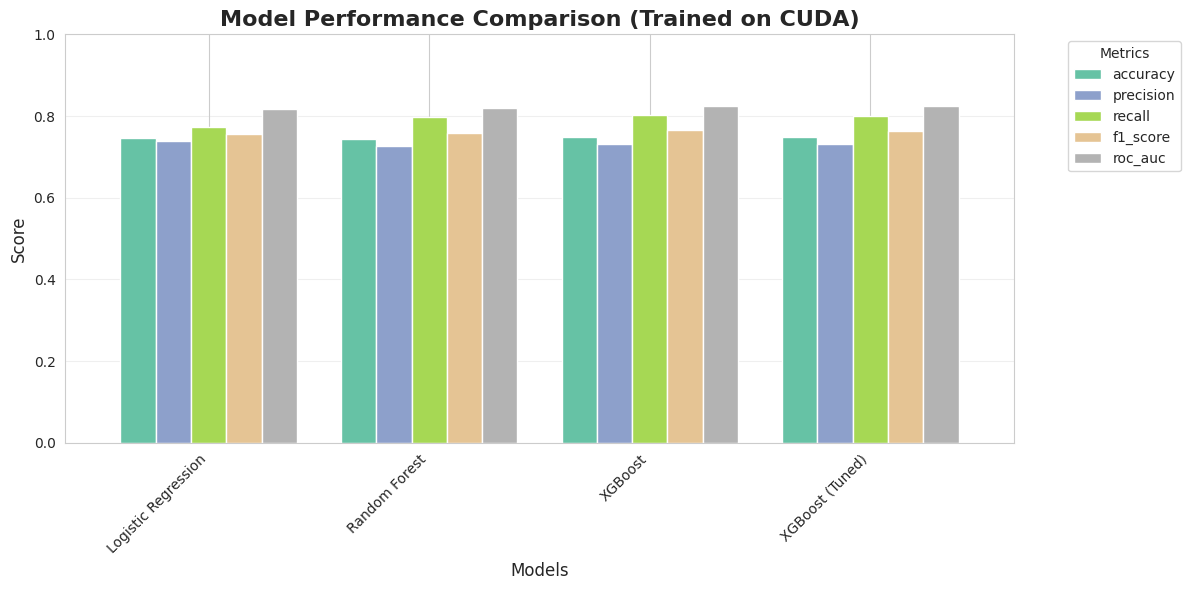

 Graph saved: 06_model_comparison.png


In [18]:
print("\n" + "="*80)
print("VISUALIZATION")
print("="*80)

results['XGBoost (Tuned)'] = final_results
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

comparison_df.to_csv('outputs/datasets/model_comparison_results.csv')
print(" Model comparison saved")

# GRAPH 6: Model Comparison
fig, ax = plt.subplots(figsize=(12, 6))
comparison_df.plot(kind='bar', ax=ax, width=0.8, colormap='Set2')
ax.set_title(f'Model Performance Comparison (Trained on {DEVICE.upper()})', fontsize=16, fontweight='bold')
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/graphs/06_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 06_model_comparison.png")


FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
             feature  importance
              HighBP    0.528594
             GenHlth    0.111697
     RiskFactorCount    0.071989
            HighChol    0.039038
                 BMI    0.034661
                 Age    0.033154
            DiffWalk    0.027040
           CholCheck    0.022488
   HvyAlcoholConsump    0.020555
HeartDiseaseorAttack    0.017701


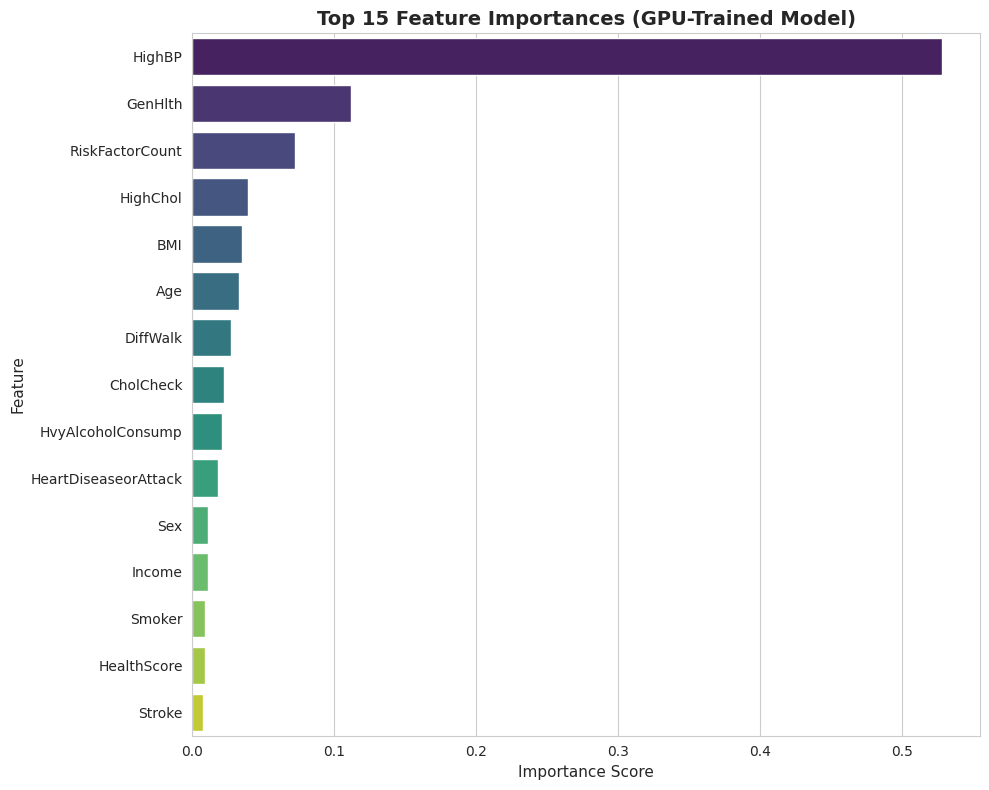


 Graph saved: 07_feature_importance.png
 Feature importance saved


In [19]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# GRAPH 7: Feature Importance
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title(f'Top 15 Feature Importances (GPU-Trained Model)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.tight_layout()
plt.savefig('outputs/graphs/07_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n Graph saved: 07_feature_importance.png")

feature_importance.to_csv('outputs/datasets/feature_importance.csv', index=False)
print(" Feature importance saved")


CONFUSION MATRIX & ROC CURVE


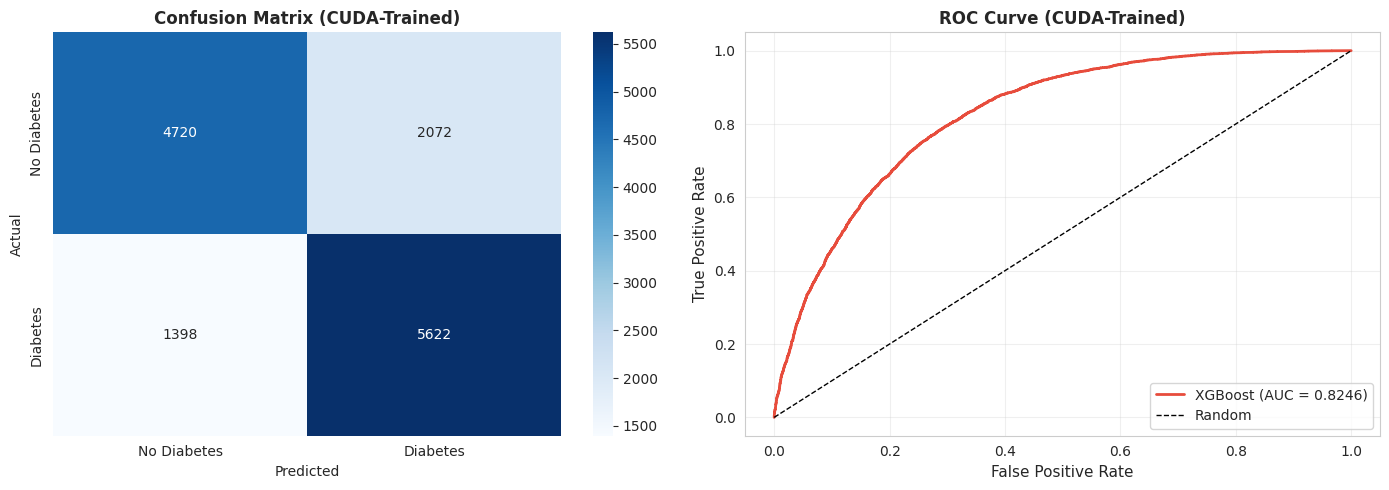

 Graph saved: 08_confusion_matrix_roc.png


In [20]:
print("\n" + "="*80)
print("CONFUSION MATRIX & ROC CURVE")
print("="*80)

cm = confusion_matrix(y_test, final_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
axes[0].set_title(f'Confusion Matrix ({DEVICE.upper()}-Trained)', fontweight='bold', fontsize=12)
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_proba)
axes[1].plot(fpr, tpr, label=f'XGBoost (AUC = {final_results["roc_auc"]:.4f})', 
             linewidth=2, color='#e74c3c')
axes[1].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title(f'ROC Curve ({DEVICE.upper()}-Trained)', fontweight='bold', fontsize=12)
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/graphs/08_confusion_matrix_roc.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 08_confusion_matrix_roc.png")


HYPOTHESIS TESTING & STATISTICAL VALIDATION

[1/5] Chi-Square Test: High Blood Pressure vs Diabetes
------------------------------------------------------------
H0: High Blood Pressure is independent of Diabetes
H1: High Blood Pressure is associated with Diabetes
Chi-Square: 9557.3231, P-value: 0.000000
Correct REJECT H0 - Significant association

[2/5] Mann-Whitney U Test: BMI Distribution
------------------------------------------------------------
U-Statistic: 815517541.0000, P-value: 0.000000
Median BMI (Diabetic): 31.00
Median BMI (Non-Diabetic): 27.00
Correct REJECT H0 - BMI differs significantly

[3/5] Independent T-Test: Age Distribution
------------------------------------------------------------
T-Statistic: 75.0304, P-value: 0.000000
Correct REJECT H0 - Age differs significantly

[4/5] Chi-Square Test: High Cholesterol vs Diabetes
------------------------------------------------------------
Chi-Square: 5467.1781, P-value: 0.000000
Correct REJECT H0 - Significant association

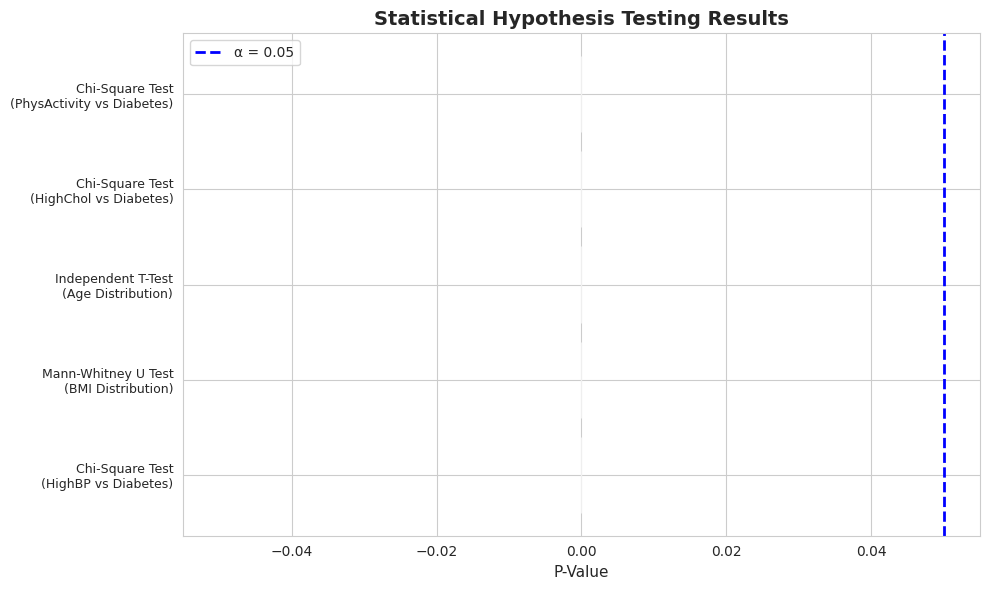

 Graph saved: 09_hypothesis_testing.png


In [21]:
print("\n" + "="*80)
print("HYPOTHESIS TESTING & STATISTICAL VALIDATION")
print("="*80)

hypothesis_results = []

# Test 1: Chi-Square - HighBP vs Diabetes
print("\n[1/5] Chi-Square Test: High Blood Pressure vs Diabetes")
print("-" * 60)

contingency_table = pd.crosstab(df['HighBP'], df['Diabetes_binary'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"H0: High Blood Pressure is independent of Diabetes")
print(f"H1: High Blood Pressure is associated with Diabetes")
print(f"Chi-Square: {chi2:.4f}, P-value: {p_value:.6f}")

conclusion = "REJECT H0 - Significant association" if p_value < 0.05 else "FAIL TO REJECT H0"
print(f"{'Correct' if p_value < 0.05 else 'Wrong'} {conclusion}")

hypothesis_results.append({
    'Test': 'Chi-Square Test',
    'Variables': 'HighBP vs Diabetes',
    'Statistic': chi2,
    'P-value': p_value,
    'Conclusion': conclusion
})

# Test 2: Mann-Whitney U - BMI
print("\n[2/5] Mann-Whitney U Test: BMI Distribution")
print("-" * 60)

bmi_diabetic = df[df['Diabetes_binary'] == 1]['BMI']
bmi_non_diabetic = df[df['Diabetes_binary'] == 0]['BMI']

statistic, p_value = mannwhitneyu(bmi_diabetic, bmi_non_diabetic, alternative='two-sided')

print(f"U-Statistic: {statistic:.4f}, P-value: {p_value:.6f}")
print(f"Median BMI (Diabetic): {bmi_diabetic.median():.2f}")
print(f"Median BMI (Non-Diabetic): {bmi_non_diabetic.median():.2f}")

conclusion = "REJECT H0 - BMI differs significantly" if p_value < 0.05 else "FAIL TO REJECT H0"
print(f"{'Correct' if p_value < 0.05 else 'Wrong'} {conclusion}")

hypothesis_results.append({
    'Test': 'Mann-Whitney U Test',
    'Variables': 'BMI Distribution',
    'Statistic': statistic,
    'P-value': p_value,
    'Conclusion': conclusion
})

# Test 3: T-Test - Age
print("\n[3/5] Independent T-Test: Age Distribution")
print("-" * 60)

age_diabetic = df[df['Diabetes_binary'] == 1]['Age']
age_non_diabetic = df[df['Diabetes_binary'] == 0]['Age']

statistic, p_value = ttest_ind(age_diabetic, age_non_diabetic)

print(f"T-Statistic: {statistic:.4f}, P-value: {p_value:.6f}")

conclusion = "REJECT H0 - Age differs significantly" if p_value < 0.05 else "FAIL TO REJECT H0"
print(f"{'Correct' if p_value < 0.05 else 'Wrong'} {conclusion}")

hypothesis_results.append({
    'Test': 'Independent T-Test',
    'Variables': 'Age Distribution',
    'Statistic': statistic,
    'P-value': p_value,
    'Conclusion': conclusion
})

# Test 4: Chi-Square - HighChol
print("\n[4/5] Chi-Square Test: High Cholesterol vs Diabetes")
print("-" * 60)

contingency_table = pd.crosstab(df['HighChol'], df['Diabetes_binary'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square: {chi2:.4f}, P-value: {p_value:.6f}")

conclusion = "REJECT H0 - Significant association" if p_value < 0.05 else "FAIL TO REJECT H0"
print(f"{'Correct' if p_value < 0.05 else 'Wrong'} {conclusion}")

hypothesis_results.append({
    'Test': 'Chi-Square Test',
    'Variables': 'HighChol vs Diabetes',
    'Statistic': chi2,
    'P-value': p_value,
    'Conclusion': conclusion
})

# Test 5: Chi-Square - PhysActivity
print("\n[5/5] Chi-Square Test: Physical Activity vs Diabetes")
print("-" * 60)

contingency_table = pd.crosstab(df['PhysActivity'], df['Diabetes_binary'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-Square: {chi2:.4f}, P-value: {p_value:.6f}")

conclusion = "REJECT H0 - Significant association" if p_value < 0.05 else "FAIL TO REJECT H0"
print(f"{'Correct' if p_value < 0.05 else 'Wrong'} {conclusion}")

hypothesis_results.append({
    'Test': 'Chi-Square Test',
    'Variables': 'PhysActivity vs Diabetes',
    'Statistic': chi2,
    'P-value': p_value,
    'Conclusion': conclusion
})

hypothesis_df = pd.DataFrame(hypothesis_results)
hypothesis_file = 'outputs/datasets/hypothesis_testing_results.csv'
hypothesis_df.to_csv(hypothesis_file, index=False)
print(f"\n Hypothesis testing results saved: {hypothesis_file}")

# GRAPH 9: Hypothesis Testing P-Values
plt.figure(figsize=(10, 6))
colors = ['green' if p < 0.05 else 'red' for p in hypothesis_df['P-value']]
plt.barh(range(len(hypothesis_df)), hypothesis_df['P-value'], color=colors, alpha=0.7)
plt.yticks(range(len(hypothesis_df)), 
           [f"{row['Test']}\n({row['Variables']})" for _, row in hypothesis_df.iterrows()],
           fontsize=9)
plt.axvline(x=0.05, color='blue', linestyle='--', linewidth=2, label='α = 0.05')
plt.xlabel('P-Value', fontsize=11)
plt.title('Statistical Hypothesis Testing Results', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.savefig('outputs/graphs/09_hypothesis_testing.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Graph saved: 09_hypothesis_testing.png")


SHAP ANALYSIS

Calculating SHAP values...
 SHAP values calculated


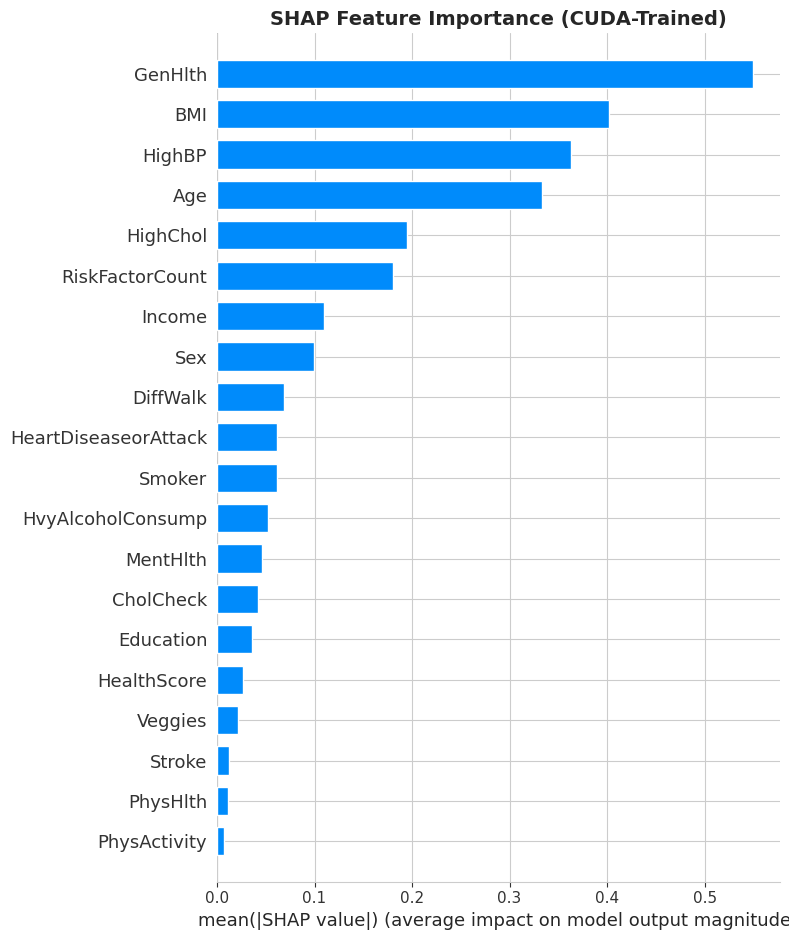

 Graph saved: 10_shap_importance.png


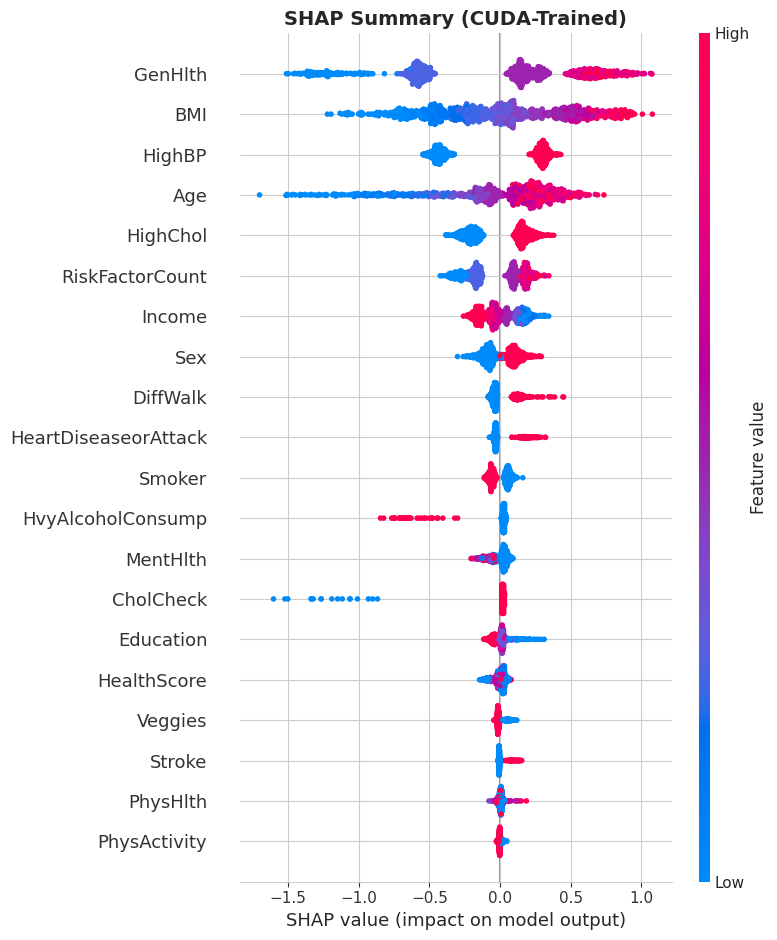

 Graph saved: 11_shap_summary.png

 SHAP analysis completed


In [23]:
print("\n" + "="*80)
print(f"SHAP ANALYSIS")
print("="*80)

if SHAP_AVAILABLE:
    try:
        print(f"\nCalculating SHAP values...")
        
        explainer = shap.TreeExplainer(final_model)
        
        sample_size = min(1000, len(X_test))
        X_test_sample = X_test.sample(n=sample_size, random_state=42)
        shap_values = explainer.shap_values(X_test_sample)
        
        print(" SHAP values calculated")
        
        # GRAPH 10: SHAP Bar
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_sample, plot_type="bar", show=False)
        plt.title(f'SHAP Feature Importance ({DEVICE.upper()}-Trained)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('outputs/graphs/10_shap_importance.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Graph saved: 10_shap_importance.png")
        
        # GRAPH 11: SHAP Summary
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_sample, show=False)
        plt.title(f'SHAP Summary ({DEVICE.upper()}-Trained)', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('outputs/graphs/11_shap_summary.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(" Graph saved: 11_shap_summary.png")
        
        print("\n SHAP analysis completed")
        
    except Exception as e:
        print(f" SHAP analysis failed: {e}")
else:
    print(" SHAP not available")


VALIDATION ON IMBALANCED DATASET
 Imbalanced dataset loaded: (253680, 22)
  Class distribution:
    No Diabetes: 218334
    Diabetes: 35346

 Feature engineering applied
Making predictions...

Validation Results:
  Accuracy:  0.7202
  Precision: 0.3077
  Recall:    0.8066
  F1-Score:  0.4455
  ROC-AUC:   0.8349


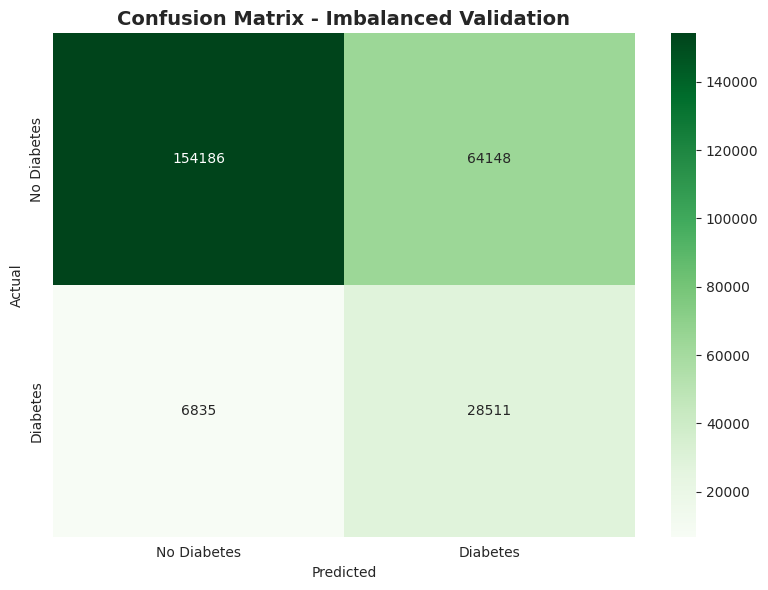


 Graph saved: 12_imbalanced_confusion_matrix.png
 Validation completed


In [25]:
print("\n" + "="*80)
print("VALIDATION ON IMBALANCED DATASET")
print("="*80)

try:
    df_imbalanced = pd.read_csv('/kaggle/input/dsc-project-dataset/diabetes_binary_health_indicators_BRFSS2015.csv')
    
    print(f" Imbalanced dataset loaded: {df_imbalanced.shape}")
    print(f"  Class distribution:")
    print(f"    No Diabetes: {(df_imbalanced['Diabetes_binary']==0).sum()}")
    print(f"    Diabetes: {(df_imbalanced['Diabetes_binary']==1).sum()}")
    
    df_imbalanced = engineer_features(df_imbalanced)
    
    X_imb = df_imbalanced.drop('Diabetes_binary', axis=1)
    y_imb = df_imbalanced['Diabetes_binary']
    X_imb = X_imb[X_train.columns]
    
    print("\n Feature engineering applied")
    print(f"Making predictions...")
    
    imb_pred = final_model.predict(X_imb)
    imb_proba = final_model.predict_proba(X_imb)[:, 1]
    
    print(f"\nValidation Results:")
    print(f"  Accuracy:  {accuracy_score(y_imb, imb_pred):.4f}")
    print(f"  Precision: {precision_score(y_imb, imb_pred):.4f}")
    print(f"  Recall:    {recall_score(y_imb, imb_pred):.4f}")
    print(f"  F1-Score:  {f1_score(y_imb, imb_pred):.4f}")
    print(f"  ROC-AUC:   {roc_auc_score(y_imb, imb_proba):.4f}")
    
    cm_imb = confusion_matrix(y_imb, imb_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_imb, annot=True, fmt='d', cmap='Greens',
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'])
    plt.title(f'Confusion Matrix - Imbalanced Validation', fontsize=14, fontweight='bold')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig('outputs/graphs/12_imbalanced_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("\n Graph saved: 12_imbalanced_confusion_matrix.png")
    
    print(" Validation completed")
    
except Exception as e:
    print(f" Validation skipped: {e}")

In [26]:

print("\n" + "="*80)
print("SAVING MODELS AND ARTIFACTS")
print("="*80)

joblib.dump(final_model, 'outputs/models/diabetes_prediction_model.pkl')
print(" Model saved: diabetes_prediction_model.pkl")

joblib.dump(scaler, 'outputs/models/feature_scaler.pkl')
print(" Scaler saved: feature_scaler.pkl")

joblib.dump(X_train.columns.tolist(), 'outputs/models/feature_names.pkl')
print(" Feature names saved: feature_names.pkl")

# Save GPU info
gpu_config = {
    'device': DEVICE,
    'tree_method': TREE_METHOD,
    'gpu_available': GPU_AVAILABLE,
    'gpu_info': GPU_INFO
}
joblib.dump(gpu_config, 'outputs/models/gpu_config.pkl')
print(" GPU configuration saved: gpu_config.pkl")


SAVING MODELS AND ARTIFACTS
 Model saved: diabetes_prediction_model.pkl
 Scaler saved: feature_scaler.pkl
 Feature names saved: feature_names.pkl
 GPU configuration saved: gpu_config.pkl


In [30]:
def predict_diabetes_risk(input_features):
    """GPU-accelerated prediction function"""
    
    model = joblib.load('outputs/models/diabetes_prediction_model.pkl')
    feature_names = joblib.load('outputs/models/feature_names.pkl')
    
    input_df = pd.DataFrame([input_features])
    
    input_df['HealthScore'] = (input_df['GenHlth'] + 
                                input_df['PhysHlth'] + 
                                input_df['MentHlth']) / 3
    
    risk_factors = ['HighBP', 'HighChol', 'Smoker', 'HeartDiseaseorAttack', 'Stroke']
    input_df['RiskFactorCount'] = input_df[risk_factors].sum(axis=1)
    
    input_df = input_df[feature_names]
    
    probability = model.predict_proba(input_df)[0, 1]
    prediction = model.predict(input_df)[0]
    
    if probability > 0.7:
        recommendation = "HIGH RISK: Immediate consultation recommended"
        risk_level = "High Risk"
    elif probability > 0.4:
        recommendation = "MODERATE RISK: Lifestyle modifications recommended"
        risk_level = "Moderate Risk"
    else:
        recommendation = "LOW RISK: Maintain healthy lifestyle"
        risk_level = "Low Risk"
    
    return {
        'prediction': 'Diabetes Risk Detected' if prediction == 1 else 'No Diabetes Risk',
        'risk_level': risk_level,
        'probability': round(probability * 100, 2),
        'recommendation': recommendation,
        'computed_on': DEVICE.upper()
    }

print("\nTesting Prediction Function:")
print("-" * 60)

example_patient = {
    'HighBP': 1, 'HighChol': 1, 'CholCheck': 1, 'BMI': 32, 'Smoker': 0,
    'Stroke': 0, 'HeartDiseaseorAttack': 0, 'PhysActivity': 0, 'Fruits': 0,
    'Veggies': 0, 'HvyAlcoholConsump': 0, 'AnyHealthcare': 1, 'NoDocbcCost': 0,
    'GenHlth': 3, 'MentHlth': 5, 'PhysHlth': 10, 'DiffWalk': 1, 'Sex': 0,
    'Age': 9, 'Education': 4, 'Income': 3
}

result = predict_diabetes_risk(example_patient)
print(f"Prediction: {result['prediction']}")
print(f"Risk Level: {result['risk_level']}")
print(f"Probability: {result['probability']}%")
print(f"Recommendation: {result['recommendation']}")


Testing Prediction Function:
------------------------------------------------------------
Prediction: Diabetes Risk Detected
Risk Level: High Risk
Probability: 82.81%
Recommendation: HIGH RISK: Immediate consultation recommended
